# This notebook is deticated to create recommendations engines

## Importing libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Loading Tables

- Loading the selected tables from data store to apply for recommendations engines

In [3]:
event = pd.read_csv('medalion_data_store/bronze/events.csv')
unique_event_features = pd.read_csv('medalion_data_store/silver/unique_event_features.csv')
user_item_profile = pd.read_csv('medalion_data_store/gold/user_item_profile.csv')

# Rank-Based Recommendations

Rank-Based Recommendation is a -simple- yet effective approach that ranks items based on predefined criteria and suggests the top-ranked items to users.

## Steps

---

### 1. Ranking Offers Using `unique_event_features` Table
- Extract relevant features from the `unique_event_features` table.
- Define a ranking criterion, such as:
  - User engagement metrics (e.g., offer completed, completion rate).
- Sort the offers based on the selected ranking metric.

### 2. Generating Recommendations
- Use the ranked offers table along with the event data to personalize recommendations:
  - Filter relevant offers.
  - Select the top-ranked items to generate a recommendation list.
  - Ensure that only previously unseen are included in the recommendation.

---

### Creating an offer ranked table

In [94]:
# Grouping data by 'ofr_id_short' and aggregating relevant metrics
rank = unique_event_features.groupby('ofr_id_short').agg(
    sum_receiv=('cnt_received', 'sum'),  # Total received count
    sum_view=('cnt_viewed', 'sum'),      # Total viewed count
    sum_comp=('cnt_completed', 'sum'),   # Total completed count
    sum_influ=('influence', 'sum'),      # Total influence
    sum_exinfl=('ext_influence', 'sum'), # Total external influence
    mean_curiosity=('curiosity_vr', 'mean'),  # Average curiosity score
    mean_eagerm=('eagerness_cv', 'mean'),    # Average eagerness score
    mean_overall=('overall_cr', 'mean')      # Average overall conversion rate
).reset_index()

# Calculating additional performance metrics
rank['completition_rate'] = rank['sum_comp'] / rank['sum_receiv']*100
rank['viewed_rate'] = rank['sum_view'] / rank['sum_receiv']*100

# Rounding numeric values to one decimal place for clarity
rank = rank.round(1)

rank = rank.sort_values(by=['sum_influ', 'completition_rate'], ascending=False)

# saving the ranked table
rank.to_csv('medalion_data_store/gold/offer_ranked.csv')


# Display the final DataFrame
rank.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 6 to 7
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ofr_id_short       10 non-null     object 
 1   sum_receiv         10 non-null     float64
 2   sum_view           10 non-null     float64
 3   sum_comp           10 non-null     float64
 4   sum_influ          10 non-null     int64  
 5   sum_exinfl         10 non-null     int64  
 6   mean_curiosity     10 non-null     float64
 7   mean_eagerm        10 non-null     float64
 8   mean_overall       10 non-null     float64
 9   completition_rate  10 non-null     float64
 10  viewed_rate        10 non-null     float64
dtypes: float64(8), int64(2), object(1)
memory usage: 960.0+ bytes


### Defining a Rank-Based recommendation function

In [168]:
# Function to recommend offers based on ranking and past interactions
def offer_rank_recommendation(person_id, event, offer_rank):
    """
    Recommends offers that the person has not seen yet,
    prioritizing those with higher influence and completion rates.
    
    Parameters:
    person_id (str): The unique identifier of the person.
    event (pd.DataFrame): The event data containing past interactions.
    offer_rank (pd.DataFrame): The ranked offers data.
    
    Returns:
    list: A list of recommended offer IDs sorted by priority.
    """
    # Get offers that the person has already seen
    products_seen = event[event['person'] == person_id]['ofr_id_short'].unique()

    # Filter out seen offers and sort remaining offers by influence and completion rate
    products_not_seen = (
        offer_rank[~offer_rank['ofr_id_short'].isin(products_seen)]
        .sort_values(by=['sum_influ', 'completition_rate'], ascending=False)['ofr_id_short']
        .tolist()
    )

    print('*** Rank-Based Recommendations ***\n')
    print(f'The person saw: {products_seen}')
    print(f'The recommended offers to person {person_id} are: {products_not_seen}')
    print('------------------\n')
    
    return products_not_seen  # Optionally, return only the top N recommendations

### Checking for a user

In [120]:
# Example usage
r1 = pd.Series(offer_rank_recommendation('01d26f638c274aa0b965d24cefe3183f', event, rank), name='01d26f638c274aa0b965d24cefe3183f')

*** Rank-Based Recommendations ***

The person saw: ['ofr_E' 'ofr_C' 'ofr_H']

The recommended offers to person 01d26f638c274aa0b965d24cefe3183f are: ['ofr_G', 'ofr_F', 'ofr_I', 'ofr_B', 'ofr_A', 'ofr_D', 'ofr_J']



In [121]:
r2 = pd.Series(offer_rank_recommendation('ffff82501cea40309d5fdd7edcca4a07', event, rank), name='ffff82501cea40309d5fdd7edcca4a07')

*** Rank-Based Recommendations ***

The person saw: ['ofr_G' 'ofr_E' 'ofr_J' 'ofr_D']

The recommended offers to person ffff82501cea40309d5fdd7edcca4a07 are: ['ofr_F', 'ofr_I', 'ofr_B', 'ofr_A', 'ofr_C', 'ofr_H']



# User-User Collaborative Filtering

User-User Collaborative Filtering is a recommendation technique that finds similar users based on their interactions and preferences or segment to suggest items.

## Steps

--- 

### 1. Creating a User-Item Matrix
- Creating the matrix where rows represent users, and columns represent items.
- Each cell contains a value representing the interaction between the user and the item AND his segment (gender, age group).

> note: Segmented user similarity can be done choosing features targuet in the dataset `user_item_profile`.

### 2. Scaling the Data
- Since different users may have different interaction levels, scaling is necessary.
- Apply an appropriate scaler depending on the data type:
  - **StandardScaler**: If data follows a normal distribution.
  - **MinMaxScaler**: If values need to be normalized between a range.

### 3. Calculating Cosine Similarity
- Compute the pairwise similarity between users using **Cosine Similarity**.

- This generates a **User-User Similarity Matrix**, where each entry \((i, j)\) represents the similarity between users \(i\) and \(j\).

### 4. Generating Recommendations
- For a target user:
  - Identify the most similar users (neighbors) based on the similarity matrix.
  - Aggregate their interactions to predict scores for items the target user has not interacted with.
  - Rank items based on predicted scores and recommend the highest-ranked items.

---

### Creating USER-ITEM matrix

In [93]:
# creating user-item matrix choosing all feature in user_item_matrix
user_item_matrix = (pd.concat([
    user_item_profile.drop(columns=['age_group']),
    pd.get_dummies(user_item_profile['age_group'], dummy_na=True, prefix='age').astype(int),
    pd.get_dummies(user_item_profile['gender'], dummy_na=True, prefix='gen').astype(int)
    ], axis=1)
    .drop(columns=['age', 'gender', 'became_member_on', 'bec_memb_year_month'])
    .dropna()
    #.fillna(0)
    )

# setting index as person id
user_item_matrix.index = user_item_matrix['id']
user_item_matrix = user_item_matrix.drop(columns=['id'])

user_item_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14487 entries, 0610b486422d4921ae7d2bf64640c50b to e4052622e5ba45a8b96b59aba68cf068
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   income               14487 non-null  float64
 1   cnt_completed_ofr_G  14487 non-null  float64
 2   cnt_completed_ofr_I  14487 non-null  float64
 3   cnt_completed_ofr_J  14487 non-null  float64
 4   cnt_received_ofr_C   14487 non-null  float64
 5   cnt_received_ofr_G   14487 non-null  float64
 6   cnt_received_ofr_H   14487 non-null  float64
 7   cnt_received_ofr_I   14487 non-null  float64
 8   cnt_received_ofr_J   14487 non-null  float64
 9   cnt_viewed_ofr_C     14487 non-null  float64
 10  cnt_viewed_ofr_G     14487 non-null  float64
 11  cnt_viewed_ofr_H     14487 non-null  float64
 12  cnt_viewed_ofr_I     14487 non-null  float64
 13  cnt_completed_ofr_D  14487 non-null  float64
 14  cnt_completed_ofr_E  14487 non-nu

### Scalling dataset

- As scaler is sensible to data distribution, it will show if there is a normal aspect

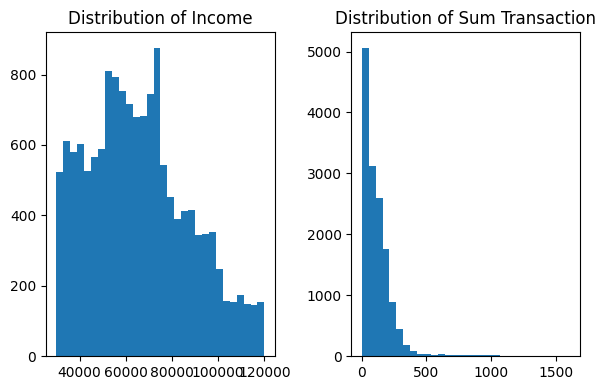

NOT seem like normal!


In [36]:
# Instantiate figure
fig, axes = plt.subplots(1, 2, figsize=(6, 4)) 

# histograms contruction
axes[0].hist(user_item_matrix['income'], bins=30)
axes[0].set_title('Distribution of Income')

axes[1].hist(user_item_matrix['sum_transaction'], bins=30)
axes[1].set_title('Distribution of Sum Transaction')

# plotting
plt.tight_layout()
plt.show()

print('NOT seem like normal!')

- choosing MinMaxScaler as scaler function

In [95]:
df = user_item_matrix

scaler_counts = MinMaxScaler()

df = scaler_counts.fit_transform(df)

df = pd.DataFrame(df, index=user_item_matrix.index, columns=user_item_matrix.columns)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14487 entries, 0610b486422d4921ae7d2bf64640c50b to e4052622e5ba45a8b96b59aba68cf068
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   income               14487 non-null  float64
 1   cnt_completed_ofr_G  14487 non-null  float64
 2   cnt_completed_ofr_I  14487 non-null  float64
 3   cnt_completed_ofr_J  14487 non-null  float64
 4   cnt_received_ofr_C   14487 non-null  float64
 5   cnt_received_ofr_G   14487 non-null  float64
 6   cnt_received_ofr_H   14487 non-null  float64
 7   cnt_received_ofr_I   14487 non-null  float64
 8   cnt_received_ofr_J   14487 non-null  float64
 9   cnt_viewed_ofr_C     14487 non-null  float64
 10  cnt_viewed_ofr_G     14487 non-null  float64
 11  cnt_viewed_ofr_H     14487 non-null  float64
 12  cnt_viewed_ofr_I     14487 non-null  float64
 13  cnt_completed_ofr_D  14487 non-null  float64
 14  cnt_completed_ofr_E  14487 non-nu

### Creating user similarity matrix

In [45]:
# Compute user similarity
user_similarity_df = None
user_similarity = cosine_similarity(df)
user_similarity_df = pd.DataFrame(user_similarity, index=df.index, columns=df.index)
user_similarity_df

### Definning a recommendation function

In [162]:
def recommend_user_based(user_id, user_similarity_df, event):
    """
    Recommend products to a user based on similar users' preferences.
    
    Parameters:
        user_id (int/str): The ID of the target user.
        user_similarity_df (pd.DataFrame): DataFrame containing user similarity scores.
        event (pd.DataFrame): DataFrame containing user interactions with products.
    
    Returns:
        list: List of recommended product IDs.
    """
    print('*** User-User Collaborative Filtering ***\n')

    if user_id not in user_similarity_df.index:
        return ['the user is not in the similarity matrix']  # Return an empty list if the user is not in the similarity matrix



    recommendations = []
    i = 0
    while recommendations == [] or len(recommendations) < 3:
        
        # Get products that user have seem
        user_products = {x for x in event[event['person'] == user_id]['ofr_id_short']}

        # Get similar users, excluding the current user
        similar_users = user_similarity_df[user_id].drop(index=user_id).sort_values(ascending=False)
        most_similar_user = similar_users.index[i]  # Retrieve the most similar user

        # Retrieve the products interacted by most similar users
        similar_user_products = {x for x in event[event['person'] == most_similar_user]['ofr_id_short']}

        # ranking the products of the most similar user
        ranked_similar_user_products = (rank.loc[rank['ofr_id_short'].isin(similar_user_products),:]
                                        .sort_values(by=['sum_influ', 'completition_rate'], ascending=False)['ofr_id_short']
                                        ).tolist()
        
        # Recommend products that the similar user has interacted with but the current user hasn't
        recommendations = [x for x in ranked_similar_user_products if x not in user_products]
        i += 1
    
    print(f'Current user ({user_id}) products: {user_products}\n')
    print(f'First one Similar user found: {most_similar_user}')
    print(f'Products of first one similar user ({most_similar_user}): {similar_user_products}')
    print(f'Three best Recommendation(s) for current user: {recommendations}')
    print('------------------\n')

    return recommendations



## Cheking for two person

In [111]:
u1 = pd.Series(recommend_user_based('01d26f638c274aa0b965d24cefe3183f', user_similarity_df, event), name='01d26f638c274aa0b965d24cefe3183f')
u1

*** User-User Collaborative Filtering ***

Current user (01d26f638c274aa0b965d24cefe3183f) products: {'ofr_C', 'ofr_E', 'ofr_H'}

First one Similar user found: 2ca6147969524c5a8ce2b48aade075ab

Products of first one similar user (2ca6147969524c5a8ce2b48aade075ab): {'ofr_C', 'ofr_E', 'ofr_J', 'ofr_B', 'ofr_F', 'ofr_H'}

Three best Recommendation(s) for current user: ['ofr_F', 'ofr_B', 'ofr_J']



0    ofr_F
1    ofr_B
2    ofr_J
Name: 01d26f638c274aa0b965d24cefe3183f, dtype: object

In [110]:
u2 = pd.Series(recommend_user_based('2cb4f97358b841b9a9773a7aa05a9d77', user_similarity_df, event), name='2cb4f97358b841b9a9773a7aa05a9d77')
u2

*** User-User Collaborative Filtering ***

Current user (2cb4f97358b841b9a9773a7aa05a9d77) products: {'ofr_C', 'ofr_D', 'ofr_H'}

First one Similar user found: 92dc99da6df84cd8ab45f30e548bda2c

Products of first one similar user (92dc99da6df84cd8ab45f30e548bda2c): {'ofr_E', 'ofr_G', 'ofr_F', 'ofr_H', 'ofr_D'}

Three best Recommendation(s) for current user: ['ofr_G', 'ofr_F', 'ofr_E']



0    ofr_G
1    ofr_F
2    ofr_E
Name: 2cb4f97358b841b9a9773a7aa05a9d77, dtype: object

In [131]:
person_list = list({x for x in unique_event_features['person']})
person_list = person_list[:10]
person_list

['c60f5cd0bdc64124bf1c206f9bf94c64',
 'eefff7e6ce0344c2a85ab5dd21db8399',
 '829e2363d8764ef98a8aee9159028621',
 'f0a08a63363940a8bf6124a7cca1683b',
 '906a503983444d939dbb4c97e34ba9d2',
 '14b8e91e01a348198b6f4fb0f28d9ab1',
 '61b362601d934a5998c6d40737f5a62e',
 'a13ec678393e4503958b05b787a2938b',
 '01f46a5191424005af436cdf48a5da7c',
 '6c6e608242534d68bc1ad45a2d547080']

In [171]:
rank_recom = []
user_recom = []
for person in person_list:
    r = offer_rank_recommendation(person, event, rank)
    u = recommend_user_based(person, user_similarity_df, event)
    rank_recom.append(r)
    user_recom.append(u)

rank_recom = pd.DataFrame(rank_recom).fillna('-')
rank_recom.columns = [f'ofr_rec_{i}' for i in range(rank_recom.shape[1])]
rank_recom.index = person_list


user_recom = pd.DataFrame(user_recom).fillna('-')
user_recom.columns = [f'ofr_rec_{i}' for i in range(user_recom.shape[1])]
user_recom.index = person_list


*** Rank-Based Recommendations ***

The person saw: ['ofr_J' 'ofr_A' 'ofr_F' 'ofr_C']
The recommended offers to person c60f5cd0bdc64124bf1c206f9bf94c64 are: ['ofr_G', 'ofr_I', 'ofr_B', 'ofr_D', 'ofr_E', 'ofr_H']
------------------

*** User-User Collaborative Filtering ***

Current user (c60f5cd0bdc64124bf1c206f9bf94c64) products: {'ofr_C', 'ofr_F', 'ofr_J', 'ofr_A'}

First one Similar user found: da9557652a704bb59cbc84cbf2b7f7d8
Products of first one similar user (da9557652a704bb59cbc84cbf2b7f7d8): {'ofr_C', 'ofr_E', 'ofr_A', 'ofr_I', 'ofr_G'}
Three best Recommendation(s) for current user: ['ofr_G', 'ofr_I', 'ofr_E']
------------------
*** Rank-Based Recommendations ***

The person saw: ['ofr_I' 'ofr_G' 'ofr_C']
The recommended offers to person eefff7e6ce0344c2a85ab5dd21db8399 are: ['ofr_F', 'ofr_B', 'ofr_A', 'ofr_D', 'ofr_J', 'ofr_E', 'ofr_H']
------------------

*** User-User Collaborative Filtering ***

*** Rank-Based Recommendations ***

The person saw: ['ofr_H' 'ofr_A' 'ofr_D']
T

In [172]:
rank_recom

,ofr_rec_0,ofr_rec_1,ofr_rec_2,ofr_rec_3,ofr_rec_4,ofr_rec_5,ofr_rec_6,ofr_rec_7
c60f5cd0bdc64124bf1c206f9bf94c64,ofr_G,ofr_I,ofr_B,ofr_D,ofr_E,ofr_H,-,-
eefff7e6ce0344c2a85ab5dd21db8399,ofr_F,ofr_B,ofr_A,ofr_D,ofr_J,ofr_E,ofr_H,-
829e2363d8764ef98a8aee9159028621,ofr_G,ofr_F,ofr_I,ofr_B,ofr_J,ofr_E,ofr_C,-
f0a08a63363940a8bf6124a7cca1683b,ofr_G,ofr_F,ofr_B,ofr_A,ofr_J,ofr_C,ofr_H,-
906a503983444d939dbb4c97e34ba9d2,ofr_G,ofr_I,ofr_B,ofr_D,ofr_J,ofr_E,ofr_C,ofr_H
14b8e91e01a348198b6f4fb0f28d9ab1,ofr_F,ofr_B,ofr_D,ofr_J,ofr_E,ofr_C,-,-
61b362601d934a5998c6d40737f5a62e,ofr_G,ofr_F,ofr_B,ofr_A,ofr_J,ofr_E,ofr_C,ofr_H
a13ec678393e4503958b05b787a2938b,ofr_G,ofr_F,ofr_B,ofr_D,ofr_J,-,-,-
01f46a5191424005af436cdf48a5da7c,ofr_G,ofr_F,ofr_I,ofr_B,ofr_J,ofr_E,ofr_C,ofr_H
6c6e608242534d68bc1ad45a2d547080,ofr_F,ofr_I,ofr_B,ofr_A,ofr_D,ofr_J,-,-


In [173]:
user_recom

,ofr_rec_0,ofr_rec_1,ofr_rec_2
c60f5cd0bdc64124bf1c206f9bf94c64,ofr_G,ofr_I,ofr_E
eefff7e6ce0344c2a85ab5dd21db8399,the user is not in the similarity matrix,-,-
829e2363d8764ef98a8aee9159028621,ofr_I,ofr_B,ofr_J
f0a08a63363940a8bf6124a7cca1683b,the user is not in the similarity matrix,-,-
906a503983444d939dbb4c97e34ba9d2,ofr_B,ofr_E,ofr_C
14b8e91e01a348198b6f4fb0f28d9ab1,ofr_B,ofr_D,ofr_J
61b362601d934a5998c6d40737f5a62e,ofr_F,ofr_C,ofr_H
a13ec678393e4503958b05b787a2938b,ofr_G,ofr_B,ofr_J
01f46a5191424005af436cdf48a5da7c,ofr_G,ofr_J,ofr_E
6c6e608242534d68bc1ad45a2d547080,the user is not in the similarity matrix,-,-
